# Quanvolutional Neural Nets

The original writeup can be found here: https://pennylane.ai/qml/demos/tutorial_quanvolution/

The "Quanvolutional Neural Network" was originally introduced by Henderson et al. in 2019, and more informationn about the paper can be found here: https://arxiv.org/abs/1904.04767

## Intro

### Classical Convolution

In machine learning, the concept of a convolutional neural network (CNN) model is to have a local convultional layer instead of processing all of the input data globally, and CNNs are well-suited for processing images by using the same kernel to sequentially process small, local regions. The results of this convolution are typically associated with different channels of a single output pixel. The resulting output pixels are then unioned into a new object reminiscent of an image, which can then be processed by additional layers.

### Quantum Convolution

Quantum convolution is similar to the classical form described above. The following approach is similar to the one demonstrated and represented in this tutorial--not the only approach to solving this problem. \
1. A small region of the image is embedding into a quantum circuit (through a process of something like parametrized rotations of the qubits that are initialized in the ground state).
2. Then, a quantum computation (unitary, U) is performed on the system.
3. The quantum system is measured to obtain a list of classical expectation values (in our specific case, the raw expectation values for PauliZ). Note: it is also possible to classically post-process these results before using them in the next layer(s).
4. Just like with classical convolution layers, each expectation value is mapped to a separate output channel consisting of a single pixel.
5. After this process has been repeated over the various regions of the image (in our case, many 2x2 regions that overlap), the image can be essentially "reassembled" in a lower fidelity image structured as a multi-channel image.
6. The quantum convolution part of this model can be proceeded by a number of layers that are either quantum or classical. \
Quantum circuits are useful for convolutional neural networks because they can generate "highly complex kernels" whose computation could theoretically be intractable for classical computers.



## Setup

Uncomment the cells below to install pennylane and tensorflow if they are not already on your machine.

In [ ]:
# !pip install pennylane
# !pip install tensorflow

For this exercise, we'll need to import Pennylane, TensorFlow, and matplotlib.

In [ ]:
# PennyLane import
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# TensorFlow import
import tensorflow as tf
from tensorflow import keras

# Matplotlib import
import matplotlib.pyplot as plt

### Hyper-Parameter Setup

Here, we want to set up our hyper-parameters that we can easily tweak later on (i.e. number of epochs and layers or the data points in the datasets for training and testing).

In [ ]:
n_epochs = 30   # Number of epochs over which to optimize
n_layers = 1    # Number of random layers
n_train = 50    # Size of the training dataset
n_test = 30     # Size of the test dataset


# To save time later, we will save the processed data to the path below so we can skip the preprocess step in future executions
SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH

# Set the random seed so that we get the same randomness each time and can better compare our results
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading the Dataset

Since we'll be using the MNIST handwriting dataset, we can import that from Keras (in TensorFlow). For the sake of time, we'll be using only part of the dataset for this demonstration instead of training the neural network over the entire dataset. Note: This speedup in time can come at the expense of the accuracy of the model.

In [ ]:
# Import the dataset from keras
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce the dataset size to n_train data points (we set it to 50 above)
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# Reduce the dataset size to n_test data points (we set it to 30 above)
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1 since they're given as values gradient values from 0 to 255
train_images = train_images / 255
test_images = test_images / 255

# Add an extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Using a Quantum Circuit as a Convolutional Kernel

Our quantum circuit consists of
1. an embedding layer of local Ry rotations (angles scaled by a factor of $\pi$)
2. a random circuit of n_layers
3. a final measurement in the computational basis, estimating 4 expectation values

This circuit will be executed on Pennylane's "default.qubit" simulator, established by the QNode set in the following code block.

In [ ]:
# Set our quantum device (in this case, a Pennylane simulator)
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

# Establish a qnode for our device
@qml.qnode(dev)

# Define our circuit function
def circuit(phi):
    """Set up the random quantum circuit, including application of an RY gate to encode our data.

    Args:
        phi (float): Value by which we want to multiply pi to perform a rotation
          about the y-axis.

    Returns:
        tensor: The expectation value of PauliZ.
    """

    # Encode of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values for our 4 output channels
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

This next part defines how our convolution works:
1. The image is broken down in 2x2-pixel squares.
2. Each of these 2x2 squares is then processed.
3. The resulting 4 expectation values are subsequently mapped into 4 different channels of a single pixel for the output.

This process reduces the resolution of the input image by half, corresponding to a stride of 2 with a 2x2 kernel convolution.

In [ ]:
# Define quanv function
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""

    # Set an array of zeros to be filled in later with actual data
    out = np.zeros((14, 14, 4))

    # Loop over coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],                 # top left
                    image[j, k + 1, 0],             # top right
                    image[j + 1, k, 0],             # bottom left
                    image[j + 1, k + 1, 0]          # bottom right
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Pre-Processing the Data (Images)

It is more efficient to use the quantum layer as a pre-processing layer for the image data instead of training it as a convolutional layer, so that's exactly what we'll do next. It's the classical layer(s) which will be trained and tested to avoid unnecessary repetitions of quantum computations (on our simulator or on a real device should we choose to use it).

Note: Since we are preprocessing the images below and saving them in another folder, by changing "PREPROCESS == TRUE" to "PREPROCESS == FALSE" in our hyperparameter setup (near the beginning of this notebook), we can avoid preprocessing the data each subsequent time the code is run.

In [ ]:
# Only pre-process if "PREPROCESS" is set to "True", which we did in our hyper-parameter setup code block
if PREPROCESS == True:
    # Create an empty list to which we'll append our training data
    q_train_images = []
    print("Quantum pre-processing of train images:")
    # Enumerate over index and image in the training data
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        # Append convoluted image data to list
        q_train_images.append(quanv(img))
    # Convert list to a numpy array
    q_train_images = np.asarray(q_train_images)

    # Create an empty list to which we'll append our test data
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    # Enumerate over index and image in the test data
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        # Append convoluted image data to list
        q_test_images.append(quanv(img))
    # Convert list to a numpy array
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images for both training and test datasets
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images from the directory in which we saved them
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


### Visualizing the Effects of the Convolution (Input vs. Each Output Channel)

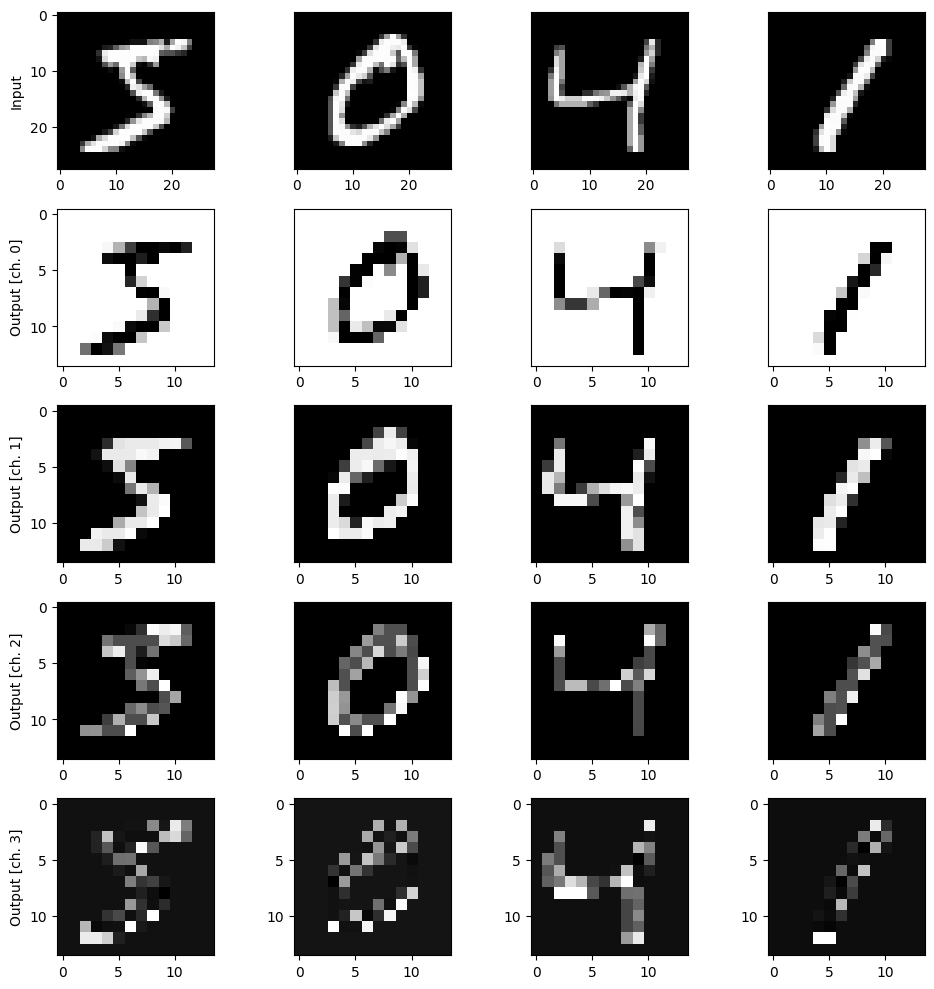

In [ ]:
# Set number of samples to be visualized and number of output channels
n_samples = 4
n_channels = 4

# Create a figure with subplots
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

# Loop over samples
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    # Plot input impage
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Loop over output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        # Plot all output channel results
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Hybrid Quantum-Classical Model

After the quantum convolutional layer, the resulting features are fed into the next layer, a classical neural network, that will be trained to classify the 10 digits in the dataset.

This classical model is composed of a single layer with 10 output nodes and a softmax activation function. It is compiled with a stochastic-gradient-descent optimizer and a cross-entropy loss function.

In [ ]:
# Define the classical part of the model
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    # Initialize the sequential model
    model = keras.models.Sequential([ ##################
        keras.layers.Flatten(), ##################
        keras.layers.Dense(10, activation="softmax") ##################
    ])

    # Compile the model
    model.compile(
        optimizer='adam', ##################
        loss="sparse_categorical_crossentropy", ##################
        metrics=["accuracy"], ##################
    )
    return model

### Training

We instantiate our model that we will use on the data that has been pre-processed by our quantum layer.

In [ ]:
# Establish quantum model
q_model = MyModel()

# Fit the model on the quantum training images + labels, referencing test data for validation, and using hyper-parameter specifications
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 90ms/step - accuracy: 0.1400 - loss: 2.5600 - val_accuracy: 0.3000 - val_loss: 2.2651
Epoch 2/30
13/13 - 0s - 23ms/step - accuracy: 0.4000 - loss: 1.8211 - val_accuracy: 0.4000 - val_loss: 2.0344
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.6000 - loss: 1.5478 - val_accuracy: 0.5000 - val_loss: 1.8809
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.8000 - loss: 1.2462 - val_accuracy: 0.5667 - val_loss: 1.7354
Epoch 5/30
13/13 - 0s - 7ms/step - accuracy: 0.8800 - loss: 1.0268 - val_accuracy: 0.5667 - val_loss: 1.6174
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.8564 - val_accuracy: 0.5667 - val_loss: 1.5348
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.7196 - val_accuracy: 0.6000 - val_loss: 1.4656
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.6099 - val_accuracy: 0.6333 - val_loss: 1.4058
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.5211 - val_accuracy: 0.7000 - val_loss: 1.3570
Epoch 10/30
13/

Next, we will instantiate our purely classical model with our initial image data (not the data that has been pre-processed by a quantum later as above).

In [ ]:
# Establish our classical model
c_model = MyModel()

# Similar to the quantum model but using original "train_images" and "test_images" as opposed to "q_train_images" or "q_test_images" as the quantum did
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 67ms/step - accuracy: 0.1600 - loss: 2.3883 - val_accuracy: 0.2000 - val_loss: 2.1667
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.4400 - loss: 1.9808 - val_accuracy: 0.2333 - val_loss: 2.0329
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.6000 - loss: 1.6960 - val_accuracy: 0.3333 - val_loss: 1.9055
Epoch 4/30
13/13 - 0s - 13ms/step - accuracy: 0.6800 - loss: 1.4588 - val_accuracy: 0.4333 - val_loss: 1.7863
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.7600 - loss: 1.2587 - val_accuracy: 0.4667 - val_loss: 1.6816
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.8200 - loss: 1.0916 - val_accuracy: 0.5333 - val_loss: 1.5930
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9200 - loss: 0.9526 - val_accuracy: 0.5667 - val_loss: 1.5186
Epoch 8/30
13/13 - 0s - 12ms/step - accuracy: 0.9200 - loss: 0.8368 - val_accuracy: 0.6333 - val_loss: 1.4561
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.7397 - val_accuracy: 0.6333 - val_loss: 1.4031
Epoch 10/30
1

## Results

We now want to visualize how the accuracy and loss changed with each epoch, so we will use MatPlotLib's PyPlot to help us visually compare.

<ipython-input-15-f47210500fd2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


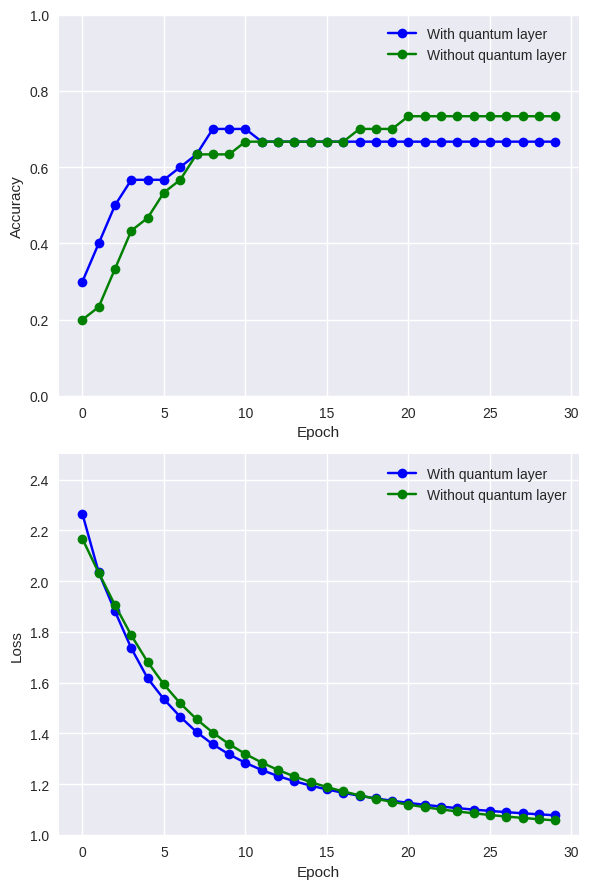

In [ ]:
# Use seaborn style of pyplot
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plot the accuracy across the epochs to visualize the change
_ = ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
_ = ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
_ = ax1.set_ylabel("Accuracy")
_ = ax1.set_ylim([0, 1])
_ = ax1.set_xlabel("Epoch")
_ = ax1.legend()

# Plot the loss across the epochs to visualize the change
_ = ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
_ = ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
_ = ax2.set_ylabel("Loss")
_ = ax2.set_ylim(top=2.5)
_ = ax2.set_xlabel("Epoch")
_ = ax2.legend()
plt.tight_layout()
plt.show()